# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance

from Functions import *

def find_permutation_importance(model, Xfull, Yfull, n_iter):
    # instantiate permuter object
    permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', cv='prefit', n_iter=n_iter)
    permuter.fit(Xfull.values, Yfull)
    # Create a dataframe containing the mean results (and std)
    pi_meanvalues_df = pd.DataFrame({'feature':Xfull.columns,
                  'importance':permuter.feature_importances_,
                  'Feature_importance_std': permuter.feature_importances_std_}).sort_values('importance', ascending = True)
    # Get the raw results for each permutation, and store as a dataframe
    pi_raw_results = permuter.results_  
    raw_importances = pd.DataFrame({'feature_list':list(Xfull.columns)})
    for num,results in enumerate(permuter.results_):
        raw_importances[num] = results
    raw_importances =raw_importances.sort_values(by=0, ascending=False)
    raw_importances.reset_index(drop = True, inplace=True)
    
    # Get just the features that scored more highly than a random feature
    return pi_meanvalues_df, raw_importances

## Read in formatted data

In [2]:
data = pd.read_csv("../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors.csv", index_col = False)

### Delete unneeded columns
We currently include data from all sensors (even incomplete ones)

In [3]:
sensor_ids = data['sensor_id']
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

In [4]:
# Filter columns using the regex pattern in function input
regex_pattern = 'buildings$|furniture$|landmarks$'
data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()

### Add a random variable (to compare performance of other variables against)

In [5]:
rng = np.random.RandomState(seed=42)
data['random'] = np.random.random(size=len(data))
data["random_cat"] = rng.randint(3, size=data.shape[0])

## Prepare data for modelling 
### Split into predictor/predictand variables

In [6]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Store the (non Sin/Cos) time columns and then remove them
Need them later to segment the results by hour of the day

In [7]:
data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [8]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(n_estimators = 10,random_state = 1, n_jobs = 32)]])
# xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',XGBRegressor(random_state=1, n_jobs = 200)]])
# et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (n_estimators = 500, random_state = 1, n_jobs = 32)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [9]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [10]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$'}

### Loop through each combination of the models, and the variables to include in the modelling

In [11]:
def run_model_with_cv_and_predict(model,model_name, metrics, cv, X_data, Y_data, regex_name, regex_pattern):
    print("Running {} model, variables include {}".format(model_name,  regex_name))

    # Get list of all features
    feature_list = list(X_data.columns)
        
    # Perform cross validation, time how long it takes
    start = time()
    model_output = cross_validate(model, X_data, Y_data, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
    predictions = cross_val_predict(model, X_data,Y_data,cv=cv)
    end = time()
    
    #  Create a dataframe containng scores for each performance metric
    df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
         'r2': round(abs(model_output['test_r2'].mean()),2), 'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                     index =["{}_{}".format(model_name, regex_name)])
    
    # Get the estimators 
    estimators = model_output['estimator']
    
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    return [estimators, df, feature_list, predictions]   

In [12]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

# models_dict = {"linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline, 
#                "rf_regressor":rf_model_pipeline, "et_regressor":et_model_pipeline}
models_dict = {"rf_regressor":rf_model_pipeline}
for model_name,model in models_dict.items():
    for regex_name, regex in column_regex_dict.items():
        # Run the model: return the estimators and a dataframe containing evaluation metrics
        estimators, error_metrics_df, feature_list, predictions = run_model_with_cv_and_predict(
            model, model_name, error_metrics, cv_parameters, Xfull, Yfull, regex_name, regex) 
        # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
        error_metric_scores = error_metric_scores.append(error_metrics_df)
        
        # Create dataframe of feature importances (no feature importances for linear regression)
        if model_name != 'linear_regressor':
            feature_importances = pd.DataFrame(index =[feature_list])
            for idx,estimator in enumerate(estimators):
                    feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
            feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

Running rf_regressor model, variables include withsubtypes
Ran in 34 minutes


In [14]:
# model=rf_model_pipeline
# cv =cv_parameters
# X_data=Xfull
# Y_data=Yfull
# metrics=error_metrics
# buffer_size_m=50
# # regex_name =
# # regex = 

In [15]:
# # # Perform cross validation, time how long it takes
# # start = time()
# # print("running cross_validate")
# # model_output = cross_validate(model, X_data, Y_data, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
# # print("ran cross_validate")    


# #  Create a dataframe containng scores for each performance metric
# df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
#                   'map': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
#                   'r2': round(abs(model_output['test_r2'].mean()),2), 
#                   'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
#                  index =["{}_{}".format(buffer_size_m, regex_name)])
# df
# # Get the estimators 
# # estimators = model_output['estimator']
# # print('Ran in {} minutes'.format(round((end - start)/60),2))


### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

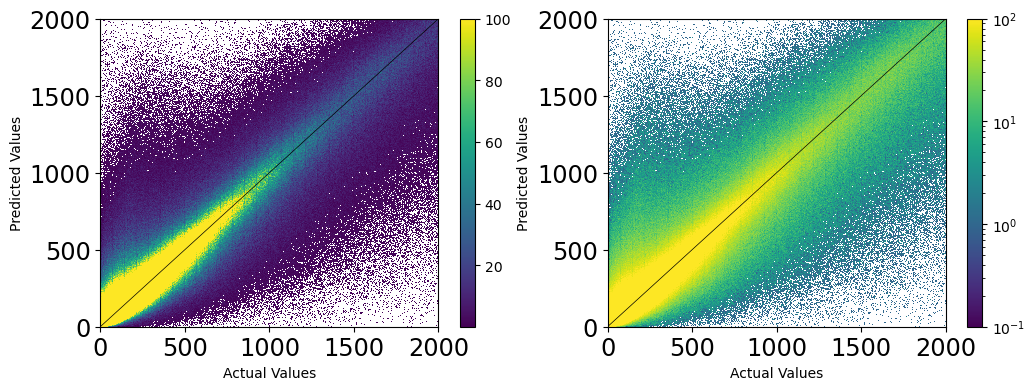

In [16]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')
axs[0].set_xlim([0, 2000])
axs[0].set_ylim([0, 2000])
using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')
axs[1].set_xlim([0, 2000])
axs[1].set_ylim([0, 2000]);

### Print the accuracy scores

In [17]:
error_metric_scores

,mae,r2,rmse
rf_regressor_withsubtypes,89.93,0.87,179.68


### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [79]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

#### Top 10 features for each estimator

In [80]:
important_columns=pd.DataFrame()
for column in feature_importances_df.columns[1:]:
    this_col = feature_importances_df[['Variable', column]]
    important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()[0:10]
important_columns    

,Estimator0,Estimator1,Estimator2,Estimator3,Estimator4,Estimator5,Estimator6,Estimator7,Estimator8,Estimator9
0,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time
1,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time
2,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin,furniture_Litter Bin
3,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard,furniture_Bollard
4,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area,buildings_Public Display Area
5,Sin_weekday_num,furniture_Bicycle Rails,Sin_weekday_num,buildings_Unoccupied,buildings_Unoccupied,Sin_weekday_num,Sin_weekday_num,buildings_Unoccupied,buildings_Unoccupied,Sin_weekday_num
6,buildings_Unoccupied,Sin_weekday_num,buildings_Unoccupied,Sin_weekday_num,Sin_weekday_num,buildings_Unoccupied,buildings_Unoccupied,Sin_weekday_num,Sin_weekday_num,buildings_Unoccupied
7,furniture_Bicycle Rails,buildings_Unoccupied,furniture_Bicycle Rails,furniture_Bicycle Rails,Cos_weekday_num,furniture_Bicycle Rails,furniture_Bicycle Rails,Cos_weekday_num,furniture_Bicycle Rails,furniture_Bicycle Rails
8,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,buildings_Residential,Cos_weekday_num,buildings_Residential,furniture_Bicycle Rails,Cos_weekday_num,Cos_weekday_num
9,buildings_Residential,buildings_Residential,buildings_Residential,buildings_Residential,furniture_Bicycle Rails,buildings_Residential,Cos_weekday_num,buildings_Residential,buildings_Residential,buildings_Residential


In [100]:
pi_raw = []
pi_ls = []
for estimator in estimators[:3]:
    pi, pi_raw = find_permutation_importance(estimator['rf_regressor'], Xfull, Yfull, n_iter=3)  
    pi_ls.append(pi)
    pi_raw.append(pi_raw)

### Find permutation importance from within Cross validation

In [328]:
important_columns=pd.DataFrame()
for i in list(range(0,len(pi_ls))):
    test=pi_ls[i].sort_values('importance', ascending = False)[0:25]
    test.reset_index(inplace=True, drop=True)
    important_columns["PI{}".format(i)] = test['feature']
important_columns

,PI0,PI1,PI2
0,Cos_time,Cos_time,Cos_time
1,Sin_time,Sin_time,Sin_time
2,Sin_weekday_num,Cos_weekday_num,Cos_weekday_num
3,Cos_weekday_num,furniture_Bollard,Sin_weekday_num
4,buildings_Entertainment,buildings_Entertainment,furniture_Bollard
5,furniture_Bollard,Sin_weekday_num,avg_n_floors
6,avg_n_floors,furniture_Tree Guard,buildings_Entertainment
7,furniture_Tree Guard,avg_n_floors,furniture_Tree Guard
8,buildings_Residential,buildings_Residential,Sin_month_num
9,buildings_Office,Sin_month_num,buildings_Residential


### Find the error in the predictions broken down by hour and sensor

In [216]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'Sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions)})
# Add hour of week variable
def label_hour_of_week (row):                                
    return "w{}_h{}".format(int(row['Weekday']), int(row['Hour']) )
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

,Predictions,Real_vals,Hour,Weekday,Sensor_id,AbsolouteError,hour_of_week
790,13.9,19,0,1,9,5.1,w1_h0
791,7.0,8,0,1,8,1.0,w1_h0
792,234.2,7,0,1,7,227.2,w1_h0
793,33.9,35,0,1,16,1.1,w1_h0
794,75.0,143,0,1,14,68.0,w1_h0


In [282]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))
    
# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour

In [281]:
# fig,ax =plt.subplots(figsize =(12,3), sharex=True)
# ax.bar(np.sort(df['Hour'].unique()),hourly_means,  yerr=hourly_stds )
# ax.set_title('Mean Values')
# ax.tick_params(axis='x', rotation=90)
# ax.set_xlim([1,len(df['hour_of_week'].unique()[::2])])
# ax.set_xticks(list(range(1,len(labels)))[::2])
# ax.set_xticklabels(labels[::2], rotation=90, size = 8)

# for i in range(1,7):
#     ax.axvline(x = 24*i, color = 'black', label = 'axvline - full height')

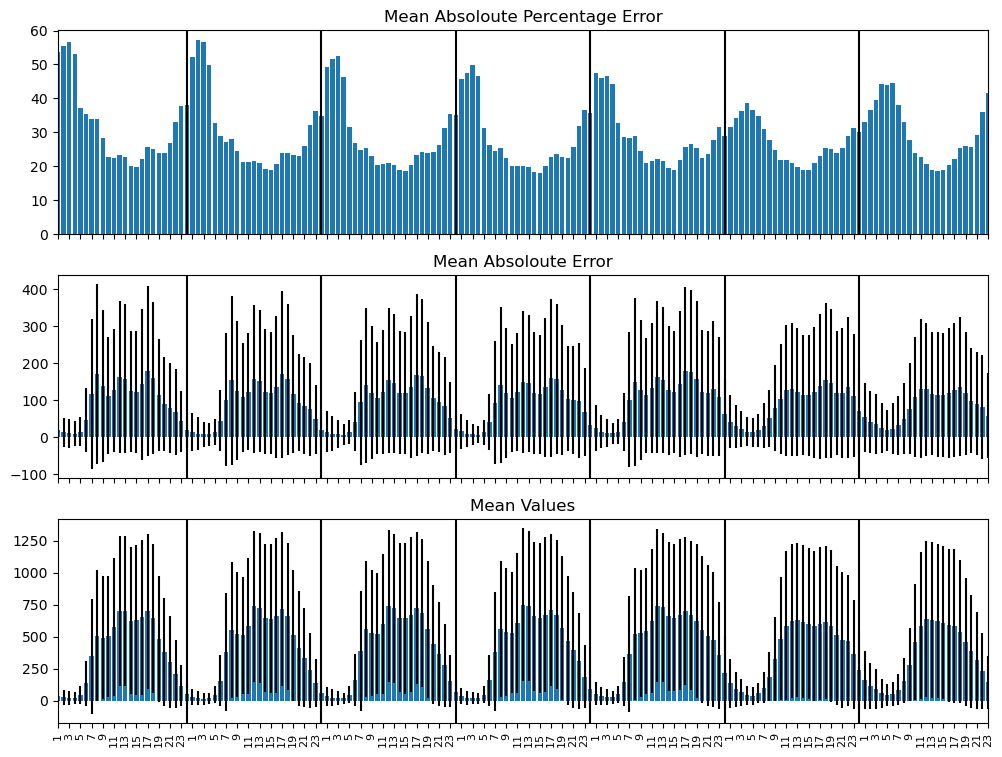

In [283]:
labels = list(range(1,25))*7

fig,axs =plt.subplots(nrows=3,figsize =(12,9), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error')
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means,  yerr=hourofweekly_stds  )
axs[2].set_title('Mean Values')
axs[2].tick_params(axis='x', rotation=90)

axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::2])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::2])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::2])])

# Axis labels
axs[0].set_xticks(list(range(1,len(labels)))[::2])
axs[0].set_xticklabels(labels[::2], rotation=90, size = 8)
axs[1].set_xticks(list(range(1,len(labels)))[::2])
axs[1].set_xticklabels(labels[::2], rotation=90, size = 8)
axs[2].set_xticks(list(range(1,len(labels)))[::2])
axs[2].set_xticklabels(labels[::2], rotation=90, size = 8)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    


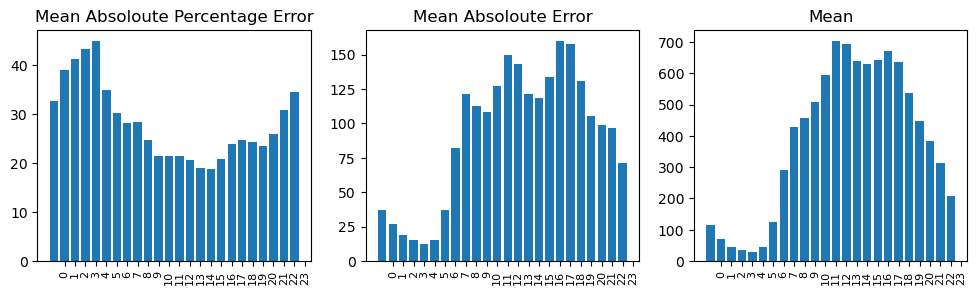

In [268]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

### Plot the errors by sensor

In [60]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [61]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

In [287]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['Mean'].min(),
                           vmax=melbourne_sensors['Mean'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)


linear.caption = "Mean hourly values"
linear.add_to(melbourne_map)
melbourne_map

In [69]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Percentage Error"
linear.add_to(melbourne_map)
melbourne_map

In [70]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Error for the sensor"
linear.add_to(melbourne_map)
melbourne_map